In [10]:
# Imports

from collections import Counter, defaultdict
from pathlib import Path
import json
import re
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [11]:
# Paths

data_path = "../data/raw-refs"
table_path = "../reports/tables"
figure_path = "../reports/figures"

In [12]:
# Find all .jsonl below data_path, recursively
jsonl_files = sorted(Path(data_path).rglob("*.jsonl"))
print(f"Found {len(jsonl_files)} jsonl files under {Path(data_path).resolve()}")
for p in jsonl_files[:5]:
    print("  -", p)

Found 2 jsonl files under /Users/martinbergsto/Documents/NTNU/Semester9/Prosjektoppgave/ML-catalogue/literature-mining/data/raw-refs
  - ../data/raw-refs/ml_planning_production/ml_planning_production.jsonl
  - ../data/raw-refs/ml_product_development/ml_product_development.jsonl


In [16]:
# Find all .jsonl files recursively under data_path

jsonl_files = sorted(Path(data_path).rglob("*.jsonl"))
print(f"Found {len(jsonl_files)} jsonl files under {Path(data_path).resolve()}")
for p in jsonl_files[:5]:
    print("  -", p)


Found 2 jsonl files under /Users/martinbergsto/Documents/NTNU/Semester9/Prosjektoppgave/ML-catalogue/literature-mining/data/raw-refs
  - ../data/raw-refs/ml_planning_production/ml_planning_production.jsonl
  - ../data/raw-refs/ml_product_development/ml_product_development.jsonl


In [14]:
# Load per-query meta from "<query_id>_meta.json" in each folder

def load_folder_meta(folder: Path) -> dict:
    """Prefer exact '<folder.name>_meta.json', else first '*_meta.json'."""
    exact = folder / f"{folder.name}_meta.json"
    if exact.exists():
        try:
            return json.loads(exact.read_text(encoding="utf-8"))
        except Exception:
            pass
    for p in sorted(folder.glob("*_meta.json")):
        try:
            return json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            continue
    return {}

query_meta = {}
for folder in {f.parent for f in jsonl_files}:
    meta = load_folder_meta(folder)
    qid = meta.get("query_id") or folder.name
    if qid not in query_meta:
        query_meta[qid] = {**meta, "folder": str(folder)}

print(f"Loaded meta for {len(query_meta)} queries from *_meta.json files.")


Loaded meta for 2 queries from *_meta.json files.


In [17]:
# Helpers 

def norm_text(s) -> str | None:
    # Normalize to lowercase string; ignore containers ([], {}, sets)
    if s is None:
        return None
    if isinstance(s, (list, tuple, set, dict)):
        return None
    s = str(s).strip().lower()
    if not s:
        return None
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^\w\s:/.-]", "", s)
    return s or None

def ref_key_from_refdoc(ref: dict) -> tuple:
    # Stable key: DOI -> title -> (id|sourcetitle) -> raw fallback
    doi = norm_text(ref.get("doi"))
    title = norm_text(ref.get("title"))
    rid = norm_text(ref.get("id"))
    src = norm_text(ref.get("sourcetitle"))
    if doi:
        return ("doi", doi)
    if title:
        return ("title", title)
    if rid or src:
        return ("id_src", f"{rid}|{src}")
    return ("raw", norm_text(json.dumps(ref, ensure_ascii=False))[:120] if ref else "unknown")

def update_meta(meta_store: dict, key: tuple, ref: dict):
    # Keep first non-null values as a representative sample
    cur = meta_store.setdefault(key, {"doi": None, "title": None, "sourcetitle": None})
    for f in ("doi", "title", "sourcetitle"):
        if cur[f] is None and ref.get(f) is not None:
            cur[f] = ref.get(f)

def infer_query_id_from_path(fp: Path) -> str:
    # Use immediate parent folder name as query_id
    return fp.parent.name

def iter_refdocs(rec: dict) -> list[dict]:
    # ref_docs is usually [] or a list of dicts; accept a single dict too
    refs = rec.get("ref_docs") or []
    if isinstance(refs, dict):
        return [refs]
    if isinstance(refs, list):
        return [r for r in refs if isinstance(r, dict)]
    return []


In [18]:
# Parse and aggregate

ref_counter = Counter()
ref_meta = {}                         # key -> meta
ref_per_query = defaultdict(Counter)  # key -> {query_id: count}
ref_per_file = defaultdict(Counter)   # key -> {filepath: count}

query_ref_totals = Counter()          # query_id -> total references counted
query_record_totals = Counter()       # query_id -> number of article rows

n_rows, n_refs, bad_refs = 0, 0, 0

for fp in tqdm(jsonl_files, desc="Files"):
    qid_from_path = infer_query_id_from_path(fp)
    with fp.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
            except json.JSONDecodeError:
                continue

            n_rows += 1
            query_id = qid_from_path or rec.get("query_id") or Path(fp.name).stem
            query_record_totals[query_id] += 1

            refs = iter_refdocs(rec)
            if rec.get("ref_docs") is not None and not refs:
                bad_refs += 1

            for ref in refs:
                key = ref_key_from_refdoc(ref)
                ref_counter[key] += 1
                ref_per_query[key][query_id] += 1
                ref_per_file[key][str(fp)] += 1
                update_meta(ref_meta, key, ref)
                query_ref_totals[query_id] += 1
                n_refs += 1

print(
    f"Parsed {n_rows} records; counted {n_refs} references; "
    f"unique refs: {len(ref_counter):,}; bad ref_docs: {bad_refs}"
)


Files: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

Parsed 3210 records; counted 44690 references; unique refs: 39,713; bad ref_docs: 2199


In [35]:
# Build overall table

rows = []
for key, cnt in ref_counter.most_common():
    meta = ref_meta.get(key, {})
    by_query = ref_per_query.get(key, {})
    rows.append(
        {
            "count": cnt,
            "n_queries": len(by_query),
            "doi": meta.get("doi"),
            "title": meta.get("title"),
            "sourcetitle": meta.get("sourcetitle"),
            "ref_key_type": key[0],
            "ref_key_value": key[1],
        }
    )

ref_df = (
    pd.DataFrame(rows)
      .sort_values(["count", "n_queries"], ascending=[False, False])
      .reset_index(drop=True)
)

print("Columns :", list(ref_df.columns))

Columns : ['count', 'n_queries', 'doi', 'title', 'sourcetitle', 'ref_key_type', 'ref_key_value']


In [37]:
# Per-query wide table 

seen_queries = sorted({q for c in ref_per_query.values() for q in c.keys()})
ordered_queries = [q for q in query_meta.keys() if q in seen_queries] + [
    q for q in seen_queries if q not in query_meta
]

if seen_queries:
    data = []
    for key, _ in ref_counter.most_common():
        row = {q: ref_per_query[key].get(q, 0) for q in ordered_queries}
        row["ref_key_type"] = key[0]
        row["ref_key_value"] = key[1]
        data.append(row)
    per_query_wide = pd.DataFrame(data)
    ref_df_wide = (
        ref_df.merge(per_query_wide, on=["ref_key_type", "ref_key_value"], how="left")
             .sort_values(["count", "n_queries"], ascending=[False, False])
             .reset_index(drop=True)
    )
else:
    ref_df_wide = ref_df.copy()

print("Wide columns", list(ref_df_wide.columns)[:12], "...")


Wide columns ['count', 'n_queries', 'doi', 'title', 'sourcetitle', 'ref_key_type', 'ref_key_value', 'ml_product_development', 'ml_planning_production'] ...


In [31]:
# Save tables (overall + by-query wide)

top_csv = Path(table_path) / "top_references_overall.csv"
wide_csv = Path(table_path) / "top_references_by_query.csv"
queries_csv = Path(table_path) / "queries_metadata.csv"

ref_df.to_csv(top_csv, index=False)
ref_df_wide.to_csv(wide_csv, index=False)

q_rows = []
for q in ordered_queries or seen_queries:
    meta = query_meta.get(q, {})
    q_rows.append({
        "query_id": q,
        "query": meta.get("query"),
        "n_returned": meta.get("n_returned"),
        "refs_attempted": meta.get("refs_attempted"),
        "retrieved_at": meta.get("retrieved_at"),
        "fetch_refs": meta.get("fetch_refs"),
        "total_records_in_jsonl": int(query_record_totals.get(q, 0)),
        "total_references_counted": int(query_ref_totals.get(q, 0)),
        "folder": meta.get("folder"),
    })
pd.DataFrame(q_rows).to_csv(queries_csv, index=False)

print(f"Saved:\n- {top_csv}\n- {wide_csv}\n- {queries_csv}")


Saved:
- ../reports/tables/top_references_overall.csv
- ../reports/tables/top_references_by_query.csv
- ../reports/tables/queries_metadata.csv


In [32]:
# Quick views

from IPython.display import display

TOP_N = 5
display(ref_df.head(TOP_N))

display(
    ref_df.sort_values(["n_queries", "count"], ascending=[False, False])
          .head(TOP_N)
          .reset_index(drop=True)
)


,count,n_queries,doi,title,sourcetitle,ref_key_type,ref_key_value
0,67,2,10.1023/A:1010933404324,Random forests,Machine Learning,doi,10.1023/a:1010933404324
1,31,2,None,Scikit-learn: Machine learning in Python,Journal of Machine Learning Research,title,scikit-learn: machine learning in python
2,25,2,10.1038/nature14539,Deep learning,Nature,doi,10.1038/nature14539
3,20,2,10.1162/neco.1997.9.8.1735,Long Short-Term Memory,Neural Computation,doi,10.1162/neco.1997.9.8.1735
4,20,2,10.1214/aos/1013203451,Greedy function approximation: A gradient boos...,Annals of Statistics,doi,10.1214/aos/1013203451


,count,n_queries,doi,title,sourcetitle,ref_key_type,ref_key_value
0,67,2,10.1023/A:1010933404324,Random forests,Machine Learning,doi,10.1023/a:1010933404324
1,31,2,None,Scikit-learn: Machine learning in Python,Journal of Machine Learning Research,title,scikit-learn: machine learning in python
2,25,2,10.1038/nature14539,Deep learning,Nature,doi,10.1038/nature14539
3,20,2,10.1162/neco.1997.9.8.1735,Long Short-Term Memory,Neural Computation,doi,10.1162/neco.1997.9.8.1735
4,20,2,10.1214/aos/1013203451,Greedy function approximation: A gradient boos...,Annals of Statistics,doi,10.1214/aos/1013203451


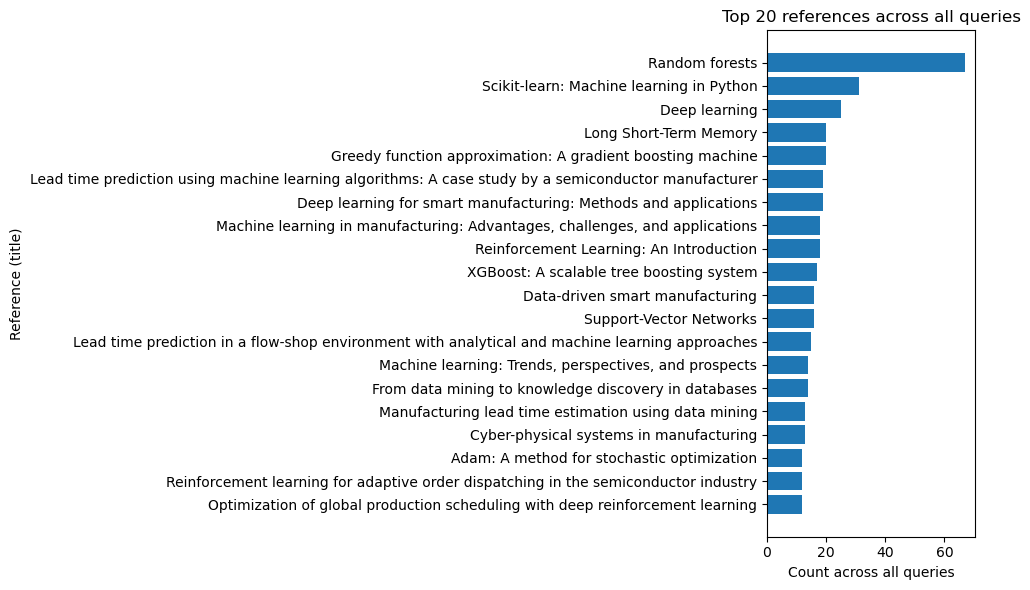

Saved figure: ../reports/figures/top_20_references.png


In [ ]:
# Figure: Top references by total count

TOP_N = 20
plot_df = ref_df.head(TOP_N).copy()

# Prefer title, fall back to DOI or source title
labels = (
    pd.Series(plot_df["title"])
      .fillna(plot_df["doi"])
      .fillna(plot_df["sourcetitle"])
      .fillna(plot_df["ref_key_value"])
)

plt.figure(figsize=(10, 6))
plt.barh(range(len(plot_df)), plot_df["count"])
plt.yticks(range(len(plot_df)), labels)
plt.gca().invert_yaxis()
plt.xlabel("Count across all queries")
plt.ylabel("Reference (title)")
plt.title(f"Top {TOP_N} references across all queries")
plt.tight_layout()

fig_path = Path(figure_path) / f"top_{TOP_N}_references.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure: {fig_path}")


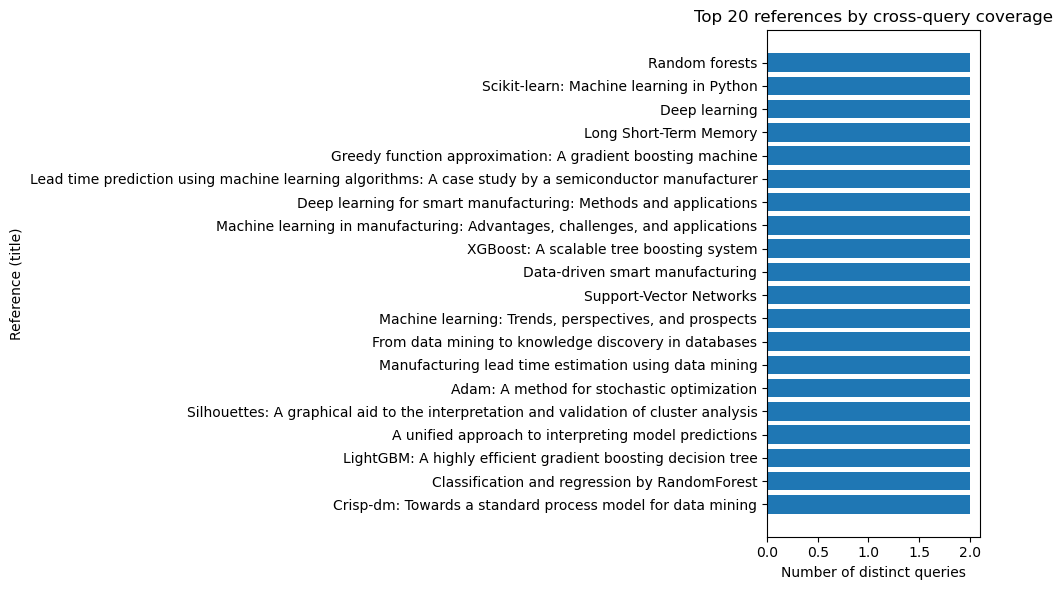

Saved figure: ../reports/figures/top_20_references_by_coverage.png


In [39]:
# Figure: Top references by distinct query coverage

TOP_N = 20
plot_df = (
    ref_df.sort_values(["n_queries", "count"], ascending=[False, False])
          .head(TOP_N)
          .copy()
)

labels = (
    pd.Series(plot_df["title"])
      .fillna(plot_df["doi"])
      .fillna(plot_df["sourcetitle"])
      .fillna(plot_df["ref_key_value"])
)

plt.figure(figsize=(10, 6))
plt.barh(range(len(plot_df)), plot_df["n_queries"])
plt.yticks(range(len(plot_df)), labels)
plt.gca().invert_yaxis()
plt.xlabel("Number of distinct queries")
plt.ylabel("Reference (title)")
plt.title(f"Top {TOP_N} references by cross-query coverage")
plt.tight_layout()

fig_path = Path(figure_path) / f"top_{TOP_N}_references_by_coverage.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure: {fig_path}")


In [40]:
# Find references by DOI/title fragment

def find_ref(fragment: str, limit: int = 50) -> pd.DataFrame:
    frag = norm_text(fragment)
    if not frag:
        return pd.DataFrame()
    hits = []
    for key, cnt in ref_counter.items():
        key_type, key_val = key
        meta = ref_meta.get(key, {})
        hay = " | ".join(
            x for x in [
                key_val,
                norm_text(meta.get("doi")),
                norm_text(meta.get("title")),
                norm_text(meta.get("sourcetitle")),
            ] if x
        )
        if hay and frag in hay:
            by_query = dict(ref_per_query.get(key, {}))
            hits.append({
                "count": cnt,
                "n_queries": len(by_query),
                "doi": meta.get("doi"),
                "title": meta.get("title"),
                "sourcetitle": meta.get("sourcetitle"),
                "ref_key_type": key_type,
                "ref_key_value": key_val,
                "by_query": by_query,
            })
    out = (
        pd.DataFrame(hits)
          .sort_values(["count", "n_queries"], ascending=[False, False])
          .head(limit)
          .reset_index(drop=True)
    )
    return out

# Example:
find_ref("10.1126/science.aal2014")


,count,n_queries,doi,title,sourcetitle,ref_key_type,ref_key_value,by_query
0,2,1,10.1126/science.aal2014,Predicting human olfactory perception from che...,Science,doi,10.1126/science.aal2014,{'ml_product_development': 2}
